<a href="https://colab.research.google.com/github/yuvvantalreja/CAPTCHA-Image-Recognition-using-CRNN-and-BiGRU/blob/main/CAPTCHA_Text_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
from torch import nn

torch.__version__

'2.3.0+cu121'

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
import requests
import os
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
data_path = Path("")

# If image folder doesn't exist commence download
if data_path.is_dir():
  print(f"{data_path} directory already exists... skipping download")
else:
  print(f"Image path doesn't exist creating one...")
  data_path.mkdir(parents = True, exist_ok = True)

with open(data_path/"data.zip", "wb") as f:
  request = requests.get("https://github.com/yuvvantalreja/CAPTCHA-Image-Recognition-using-CRNN-and-BiGRU/raw/main/data.zip")
  print("Downloading data")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path/"data.zip", "r") as zip_ref:
  print("Unzipping data")
  zip_ref.extractall(data_path)

. directory already exists... skipping download
Unzipping data


In [26]:
image_fns = os.listdir(data_path/"data")
print(len(image_fns))
print(np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

1071
[0 5]


In [27]:
for idx, image_fn in enumerate(image_fns):
    if len(image_fn.split(".")[0]) != 5:
           print(idx, image_fn)
           image_fns.remove(image_fn)

661 .DS_Store


In [28]:
image_ns = [image_fn.split(".")[0] for image_fn in image_fns]
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))
print(len(letters))
print(letters)

19
['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [29]:
vocabulary = ["-"] + letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

20
['-', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
{0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'm', 15: 'n', 16: 'p', 17: 'w', 18: 'x', 19: 'y'}
{'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'm': 14, 'n': 15, 'p': 16, 'w': 17, 'x': 18, 'y': 19}


In [30]:
import random
from PIL import Image

image_path_list = list(data_path.glob("*/*.png"))
image_path_list[0]

PosixPath('data/ng46m.png')

In [31]:
# Split into train and test data
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(image_path_list, test_size = 0.2, train_size = 0.8, random_state = 42)

len(train_set), len(test_set)

(832, 208)

Image Label: be6np


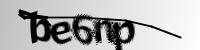

In [42]:
random.seed(42)
random_img = random.choice(image_path_list)
img = Image.open(random_img).convert('RGB')
print(f"Image Label: {str(random_img.stem)}")
img

Text(0.5, 1.0, 'Image_Label: be6np | Image Shape: (50, 200, 3)')

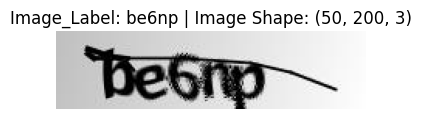

In [43]:
img_as_array = np.asarray(img)

plt.figure(figsize = (4, 3))
plt.imshow(img_as_array)
plt.axis(False)
plt.title(f"Image_Label: {str(random_img.stem)} | Image Shape: {img_as_array.shape}")

In [18]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [39]:
# Creating custom dataset

class CaptchaDataset(Dataset):
  def __init__(self, data_dir: str, image_fns: list):
    self.data_dir = data_dir
    self.image_fns = image_fns

  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self, input: int):
    image_fn = self.image_fns[input]
    # image_fp = os.path.join(self.data_dir, image_fn)
    image = Image.open(image_fn).convert('RGB')
    image = self.transform(image)
    text = str(image_fn.stem)
    return image, text

  def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)


In [40]:
train_dataset = CaptchaDataset("data/", train_set)
test_dataset = CaptchaDataset("data/", test_set)
train_dataset.__getitem__(0)

(tensor([[[1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
          [1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
          [1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
          ...,
          [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318],
          [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318],
          [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318]],
 
         [[1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
          [1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
          [1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
          ...,
          [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111],
          [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111],
          [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111]],
 
         [[1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.5703],
          [1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.5703],
          [1.5420, 1.5420, 1.5420,  ...,

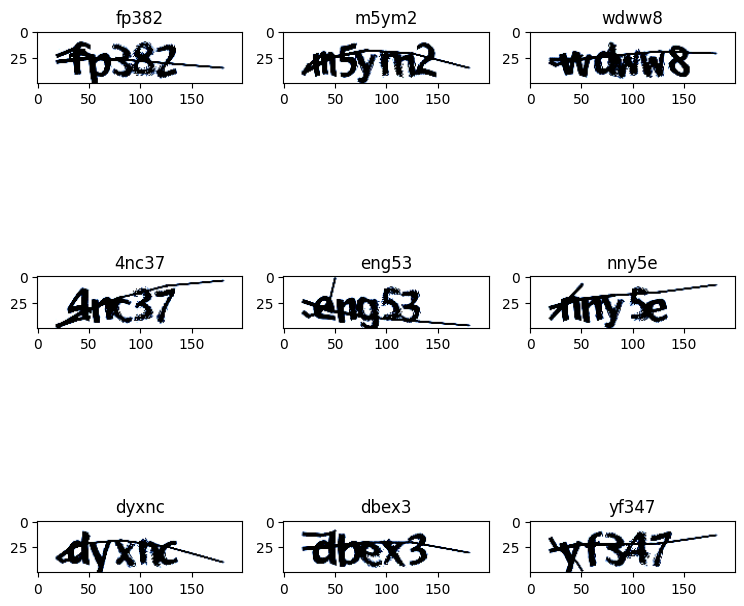

In [51]:
torch.manual_seed(0)
fig = plt.figure(figsize = (9, 9))
rows, cols = 3, 3

for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, train_dataset.__len__(), size = [1]).item()
  image, labels = train_dataset[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze().permute(1, 2, 0))
  plt.title(train_set[random_idx].stem)
  plt.axis(True)

In [ ]:
# Visualize 9 random samples from dataset

fig = plt.figure(figsize = (9, 9))
rows, cols = 9, 9

for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, len(image_path_list), size = [1]).item()
  img = image_path_list[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img)
  plt.axis(False)